# Diagramme de Moody

Chargement des modules

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd

Personnalisation de matplotlib

In [2]:
plt.rcParams['font.size']      = 12.0
plt.rcParams['legend.fontsize'] = 12.0
plt.rcParams['figure.dpi']     = 96
plt.rcParams['figure.figsize'] = (9,5)
plt.rcParams['figure.subplot.right'] = 0.8
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.left'] = 0.08

## Définition des formules

Coefficient de frottement pour un écoulement laminaire en conduite circulaire (pas d'effet de rugosité)

In [3]:
def smooth_laminar_round_pipe(Red):
    from scipy.optimize import root
    mRed = np.asarray(Red)
    return 64/Red

Coefficient de frottement pour un écoulement pleinement turbulent sur une conduite lisse

In [4]:
def smooth_pipe(Red):
    from scipy.optimize import root
    mRed = np.asarray(Red)
    def res(x):
        res = x**(-0.5) - 2.0*np.log10(mRed*x**0.5)+0.8
        return res
    sol = root(res,0.005*np.ones_like(mRed))
    return sol.x

Coefficient de frottement pour un écoulement pleinement turbulent dans une conduite rugueuse

In [5]:
def fully_rough_flow(eps_d):
    ed = np.asarray(eps_d)
    val = -2 * np.log10(ed/3.7)
    cf = (1/val)**2
    return cf

Formule implicite de Colebrook pour les écoulements turbulents sur conduite rugueuse

In [6]:
def colebrook(Red,eps_d):
    from scipy.optimize import root
    mRed = np.asarray(Red)
    def res(x):
        res = x**(-0.5) + 2.0*np.log10(eps_d/3.7+ 2.51/(mRed*x**0.5))
        return res
    sol = root(res,fully_rough_flow(eps_d)*np.ones_like(mRed))
    return sol.x

Fonction pour obtenir le Reynolds de pleinement turbulent

In [7]:
def get_int_Red(eps_d,ratio=0.987,init=4e3):
    from scipy.optimize import root
    ed = np.asarray(eps_d)
    def res(x):
        res = fully_rough_flow(ed)/colebrook(x,ed) - ratio
        return res
    sol = root(res,init*np.ones_like(ed),tol=1.0e-4)
    return sol.x

## Calculs

In [8]:
eps_d = [1e-6,5e-6,1e-5,5e-5,1e-4,2e-4,4e-4,6e-4,8e-4,1e-3,2e-3,4e-3,6e-3,8e-3,1e-2,1.5e-2,2e-2,3e-2,4e-2,5e-2]
n_ed = len(eps_d)

In [9]:
Red = np.logspace(np.log10(4e3),8,500)
lam_Red = np.logspace(np.log10(5e2),np.log10(5e3),15)

In [10]:
Moody_data = np.empty((500,n_ed))
for ied, ed in enumerate(eps_d):
    Moody_data[:,ied] = colebrook(Red,ed)

In [11]:
limit_fully_rough = get_int_Red(eps_d,ratio=0.975,init=9.0e3)

<ipython-input-6-09f13fae092b>:5: RuntimeWarning: invalid value encountered in log10
  res = x**(-0.5) + 2.0*np.log10(eps_d/3.7+ 2.51/(mRed*x**0.5))


In [12]:
Cf_smooth_pipe = smooth_pipe(Red)
Cf_smooth_lam_pipe = smooth_laminar_round_pipe(lam_Red)

## Tracé

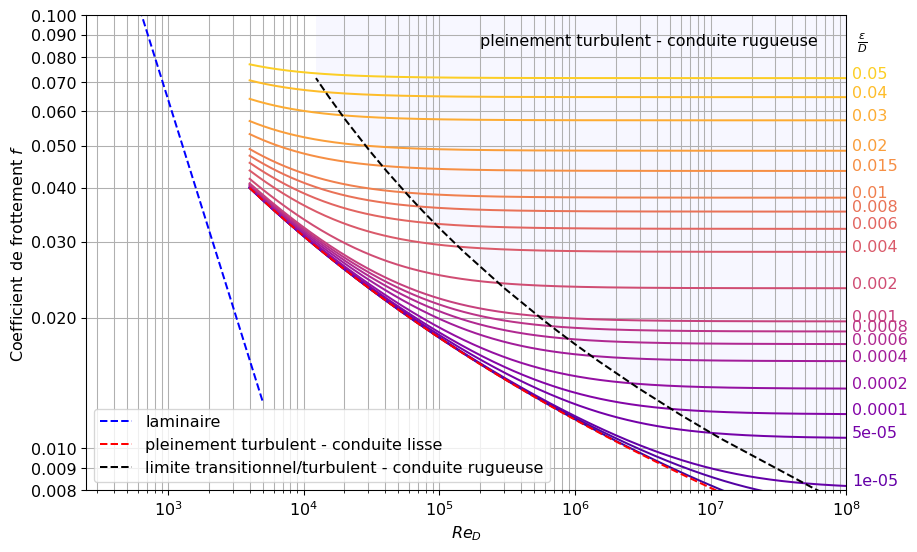

In [23]:
colors = plt.cm.plasma(np.linspace(0.1,0.9,n_ed))
fig = plt.figure(figsize=(11,6))
ax = plt.gca()
for ied in range(n_ed):
    plt.plot(Red,Moody_data[:,ied],color=colors[ied])
    if Moody_data[-1,ied]>0.008:
        plt.text(1.1e8, Moody_data[-1,ied], '{0}'.format(eps_d[ied]), color=colors[ied])
plt.text(2e5,0.085,'pleinement turbulent - conduite rugueuse')
plt.text(1.2e8,0.085,r'$\frac{\epsilon}{D}$')
plt.plot(lam_Red,Cf_smooth_lam_pipe,color='blue',linestyle='dashed',label='laminaire')
plt.plot(Red,Cf_smooth_pipe,color='red',linestyle='dashed',label='pleinement turbulent - conduite lisse')
plt.plot(limit_fully_rough,fully_rough_flow(eps_d),color='black',linestyle='dashed',
         label='limite transitionnel/turbulent - conduite rugueuse')
ax.fill_between(limit_fully_rough, fully_rough_flow(eps_d),0.1,facecolor='blue', alpha=0.03)
#                 label='pleinement turbulent - conduite rugueuse')
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both')
plt.xlabel(r'$Re_D$')
plt.ylabel(r'Coefficient de frottement $f$')
plt.xlim(None,10**8)
plt.ylim(0.008,0.1)

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs='all'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
yval = ax.get_yticklabels()
plt.legend(loc='lower left')
plt.savefig('Moody_cours.png',dpi=150)
plt.show()

